In [3]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
from IPython.display import Markdown,display
import datetime
import time

df = pd.read_csv('data/DATA_20171130.csv')

In [54]:
"""
function: select asset that contains fuel consumption information
"""
def select_subset(df,num_asset,keys,file_path1,file_path2):
    keys_fuel = ['MDI_DASHBOARD_FUEL','MDI_OBD_FUEL']
    keys_distance = ['ODO_FULL_METER','MDI_OBD_MILEAGE','MDI_DASHBOARD_MILEAGE']
    for i in range(num_asset):
        asset = df.loc[df['asset'] == i]
        #choose the asset that contains the information of gas consumption
        if len(    asset.loc[  ( ( (asset[keys_fuel[0]]!=' ') & (asset[keys_fuel[0]]!='0') ) 
                                |( (asset[keys_fuel[1]]!=' ') & (asset[keys_fuel[1]]!='0') ) 
                               )
                             & ( ( (asset[keys_distance[0]]!=' ') & (asset[keys_distance[0]]!='0') ) 
                                |( (asset[keys_distance[1]]!=' ') & (asset[keys_distance[1]]!='0') ) 
                                |( (asset[keys_distance[2]]!=' ') & (asset[keys_distance[2]]!='0') ) )] ) >0:
            file_name = str(i)+'.csv'  
            asset.to_csv(file_path1+file_name)           #original data
            asset[keys].to_csv(file_path2+file_name)     #data contains key info

#keys : import informations 
keys = ['asset','recorded_at','MDI_DASHBOARD_FUEL','MDI_OBD_FUEL','ODO_FULL_METER','MDI_OBD_MILEAGE','MDI_DASHBOARD_MILEAGE']
file_path1 = 'data/data_by_asset/'
file_path2 = 'data/data_by_asset_keys/'
#in reality many of the asset is empty. Only 5000 assets contain valide data
num_asset = 5000
select_subset(df,num_asset,keys,file_path1,file_path2)      

In [4]:
"""
function : divide a asset into small pieces according to the time interval
"""
def divise_asset_by_time(file_full_path):
    df_asset = pd.read_csv(file_full_path)
    df_list = []
    count_data = len(df_asset)
    
    start_line = 0
    for i in range(1,count_data):
        last_time      = time.mktime( datetime.datetime.strptime(df_asset.iloc[i-1]['recorded_at'], "%Y-%m-%dT%H:%M:%SZ").timetuple() )
        current_time   = time.mktime( datetime.datetime.strptime(df_asset.iloc[i]['recorded_at'], "%Y-%m-%dT%H:%M:%SZ").timetuple() )
        
        #here we consider the interval between 2 journey is greater than 30 minutes
        interval = 1800
        if current_time-last_time > interval:
            df_list.append(df_asset.iloc[start_line:i])
            start_line = i     
        if i == count_data-1:    
            df_list.append(df_asset.iloc[start_line:count_data])
    return df_list

file_path = 'data/data_by_asset_keys/'
file_name = '4.csv'
df_list = divise_asset_by_time(file_path+file_name)




max_value:  1592
min_value:  9
mean_value:  164.080447232
std_value:  167.634310749
median_value:  124.0
data count in original data  :  7334


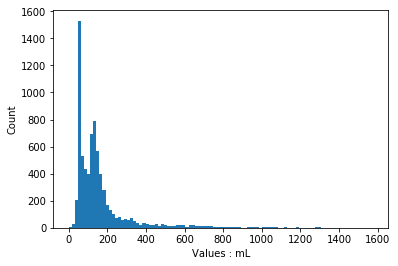

In [55]:
"""
This function is used to get the distribution of the difference between two consecutive data.
"""
def get_max_interval(file_full_path,key):
    df_asset     = pd.read_csv(file_full_path)
    count_data   = len(df_asset)
    max_index = 0
    max_interval = 0
    interval_list = []
    
    for i in range(count_data-1):
        if df_asset.iloc[i][key] == ' ' or df_asset.iloc[i+1][key]== ' ':
            continue
        current_time   = time.mktime( datetime.datetime.strptime(df_asset.iloc[i]['recorded_at'], "%Y-%m-%dT%H:%M:%SZ").timetuple() )
        current_value  = int(df_asset.iloc[i][key])
        next_time      = time.mktime( datetime.datetime.strptime(df_asset.iloc[i+1]['recorded_at'], "%Y-%m-%dT%H:%M:%SZ").timetuple() )
        next_value     = int(df_asset.iloc[i+1][key])
        
        #Under normal circumstances, acquisition interval of two consecutive data  is one minute
        if 50< next_time - current_time < 70 and next_value != ' ' and current_value != ' ':
            interval_list.append(next_value-current_value)
            if(next_value-current_value>max_interval):
                max_interval = next_value-current_value
                max_index = i
    return max_interval,max_index,interval_list

def print_data(data,unit):
    data = np.array(data)
    max_value  = np.max(data)
    min_value  = np.min(data)
    mean_value = np.mean(data)
    std_value  = np.std(data)
    median_value = np.median(data)
    print('max_value: ',max_value)
    print('min_value: ',min_value)
    print('mean_value: ',mean_value)
    print('std_value: ',std_value)
    print('median_value: ',median_value)
    print('data count in original data  : ',len(data))

    """
    If bins is an int, it defines the number of equal-width bins in the given range (10, by default). 
    If bins is a sequence, it defines the bin edges, including the rightmost edge, allowing for non-uniform bin widths.
    """
    bins = np.arange(0,max_value,  (max_value)/100 )
    plt.hist(data,bins)
    plt.xlabel('Values : '+ unit)
    plt.ylabel('Count')
    plt.show()
    
file_path = 'data/data_by_asset_keys/'
file_name = '4.csv'
key = 'MDI_OBD_FUEL'
max_interval,max_index,interval_list = get_max_interval(file_path+file_name,key)
print_data(interval_list,"mL")






In [90]:

def fill_blank_data(file_full_path,key,interval):
    df_asset     = pd.read_csv(file_full_path)
    count_data   = len(df_asset)
    index_list = []
    for i in range(count_data):
        current_time   = time.mktime( datetime.datetime.strptime(df_asset.iloc[i]['recorded_at'], "%Y-%m-%dT%H:%M:%SZ").timetuple() )
        current_value  = df_asset.iloc[i][key]
        
        #blank data to be filled
        if current_value == ' ':
            last_valide_index = None
            last_valide_time  = None
            last_valide_value = None
            next_valide_index = None
            next_valide_time  = None
            next_valide_value = None
            for j in reversed(range(i)):
                if df_asset.iloc[j][key] != ' ':
                    last_valide_index = j
                    last_valide_time  = time.mktime( datetime.datetime.strptime(df_asset.iloc[j]['recorded_at'],"%Y-%m-%dT%H:%M:%SZ").timetuple() )
                    last_valide_value = current_value  = df_asset.iloc[j][key]
                    break
            for k in range(i+1,count_data):
                if df_asset.iloc[k][key] != ' ':
                    next_valide_index = k
                    next_valide_time  = time.mktime( datetime.datetime.strptime(df_asset.iloc[k]['recorded_at'],"%Y-%m-%dT%H:%M:%SZ").timetuple() )
                    next_valide_value = current_value  = df_asset.iloc[k][key]
                    break
                    
            if last_valide_value != None and next_valide_value != None :
                interval_time  = next_valide_time  - last_valide_time
                interval_value = int(next_valide_value) - int(last_valide_value)
                
                if time.mktime( datetime.datetime.strptime(df_asset.iloc[i]['recorded_at'],"%Y-%m-%dT%H:%M:%SZ").timetuple() ) - last_valide_time <=2:
                    df_asset.loc[i, key] = str(last_valide_value)
                    index_list.append(i) 
                
                elif interval_value <= interval :
                    df_asset.loc[i, key] = str(last_valide_value)
                    index_list.append(i)               
    return df_asset,index_list


file_path = 'data/data_by_asset_keys/'
file_name = '4.csv'
key = 'MDI_OBD_FUEL'
interval = np.mean(interval_list)
df_asset,index_list = fill_blank_data(file_path+file_name,key,interval)
df_asset.to_csv('4_test_fill.csv')